In [1]:
import os
import re
import sys
import pandas as pd
import numpy as np
import glob
import yaml
import platform
import random
import math
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import kde
from collections import defaultdict
from pathlib import Path
from pyRBDome.Classes.DataFileParser import *
from pyRBDome.Functions.RBDomeAnalysisCode import *
from pyRBDome.Functions.RBDomeSQL import *
from GenbankParser.Classes.ParseGenbank import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['lines.linewidth'] = 0.75
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rc('ytick',labelsize=12)
matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('axes',labelsize=18)
%matplotlib inline
import Bio
from Bio import SeqIO

### Setting the parameters for the job:

In [2]:
settings_file = open('settings.yaml','r')
settings = yaml.load(settings_file,Loader=yaml.FullLoader)

In [3]:
### Parameters:
out_dir = os.path.abspath(settings[0]['general']['out_dir'])
data = os.path.abspath(settings[0]['general']['datafile'])
proteome = os.path.abspath(settings[0]['general']['proteome'])

### Database parameters
database_name = settings[4]['database']['database_name']
database_table = settings[4]['database']['database_table']
processed_table = settings[4]['database']['processed_files_log']

dist_analysis_log = settings[4]['database']['distance_analyses_log']
rna_bindingsite_log = settings[4]['database']['rna_bindingsite_log']

### Amino acid features and chemical properties

| chemical properties | amino acids |
| --- | --- | 
| Aliphatic (L)| alanine, glycine, isoleucine, leucine, proline, valine |
| Aromatic (R) | phenylalanine, tryptophan, tyrosine |
| Acidic (C) | aspartic acid, glutamic acid |
| Basic (B) | arginine, histidine, lysine |
| Hydroxylic (H) | serine, threonine |
| Sulphur-containing (S) | cysteine, methionine |
| Amidic (M) (containing amide group) | asparagine, glutamine |

| one letter | amino acids | three letters |
| --- | --- | --- |
| G | Glycine | Gly
| A | Alanine | Ala
| L | Leucine | Leu
| M | Methionine | Met
| F | Phenylalanine | Phe
| W | Tryptophan | Trp
| K | Lysine | Lys
| Q | Glutamine | Gln
| E | Glutamic Acid | Glu
| S | Serine | Ser 
| P | Proline | Pro
| V | Valine | Val
| I | Isoleucine | Ile
| C | Cysteine | Cys
| Y | Tyrosine | Tyr
| H | Histidine | His
| R | Arginine | Arg
| N | Asparagine | Asn
| D | Aspartic Acid | Asp
| T | Threonine | Thr

### Loading the data:

In [4]:
# For RNA-binding peptide list (RBS-ID from the paper) and for corresponding proteins
f = DataFileParser(datafile = data)
cross_linked = f.data
cross_linked = cross_linked.drop_duplicates(subset=["Protein","Peptide"],keep='first')
getProteinSequencesFromFasta(cross_linked,proteome)

/localdisk/home/openngs/openngs/packages/pyrbdome-dev-082023/pyRBDome/Classes/DataFileParser.py:62: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data.loc[:,'Peptide'] = self.data.loc[:,'Peptide'].str.replace('\\s*\\([^\\)]+\\)','')


In [5]:
cross_linked.head(3)

Protein RBS_aa  RBS_aa_location                    Peptide  \
UniProt                                                                   
P13010   XRCC5_HUMAN      C               13  LKKEDIQKETVYCLNDDDETEVLKE   
P39023     RL3_HUMAN      R               12    QVIRVIAHTQMRLLPLRQKKAHL   
Q13310   PABP4_HUMAN      G                8            NGKSKGFGFVSYEKH   

                                                  sequence  
UniProt                                                     
P13010   MVRSGNKAAVVLCMDVGFTMSNSIPGIESPFEQAKKVITMFVQRQV...  
P39023   MSHRKFSAPRHGSLGFLPRKRSSRHRGKVKSFPKDDPSKPVHLTAF...  
Q13310   MNAAASSYPMASLYVGDLHSDVTEAMLYEKFSPAGPVLSIRVCRDM...

In [6]:
cross_linked_amino_acids = defaultdict(int)
for peptide in cross_linked.RBS_aa:
    try:
        if not peptide == "-":
            cross_linked_amino_acids[peptide[0]] += 1
    except:
        continue

In [7]:
amino_acids_count_results = pd.DataFrame.from_dict(cross_linked_amino_acids,orient='index',columns=['count'])
amino_acids_count_results.sort_values(by='count',ascending=False,inplace=True)
#save copy as text file
amino_acids_count_results.to_csv(f"{out_dir}/Cross-linking_sites_counts.txt",sep="\t")
#save copy in database
#dataframeToSQLite_append_only_new(amino_acids_count_results,'Cross_linking_sites_counts',database_name)

In [8]:
fig,ax = plt.subplots(figsize=[5,4])
amino_acids_count_results.plot.bar(rot=0,width=0.85,color='k',alpha=0.7,ax=ax)
ax.set_xlabel("Amino acid")
ax.set_ylabel("Counts")
fig.savefig(f"{out_dir}/Cross_linked_amino_acids_barplot.pdf",dpi=400)

### Now converting the cross-linked amino acids to features:

In [9]:
cross_linked_features = defaultdict(int)
for peptide in cross_linked.RBS_aa:
    try:
        if not peptide == "-":
            aminoacid_properties = convertPeptideSeqToFeatureString(peptide[0])
            cross_linked_features[aminoacid_properties] += 1
    except:
        continue

In [10]:
cross_linked_features_results = pd.DataFrame.from_dict(cross_linked_features,orient='index',columns=['count'])
cross_linked_features_results.sort_values(by='count',ascending=False,inplace=True)
#save copy as text file
cross_linked_features_results.to_csv(f"{out_dir}/Cross-linking_sites_properties_counts.txt",sep="\t")
#save copy in database
#dataframeToSQLite_append_only_new(cross_linked_features_results,'Cross_linking_sites_properties_counts',database_name)

In [11]:
fig,ax = plt.subplots(figsize=[5,4])
cross_linked_features_results.plot.bar(rot=0,width=0.85,color='k',alpha=0.7,ax=ax)
ax.set_xlabel("Amino acid property")
ax.set_ylabel("Counts")
fig.savefig(f"{out_dir}/Cross_linked_amino_acid_properties_barplot.pdf",dpi=400)

### This is great but we need to normalise the data to the total number of amino acids in each protein to calculate cross-linkning frequencies. For this we would need to divide these counts by the total number of that amino acid within the proteins

In [12]:
collapsed = cross_linked[~cross_linked.index.duplicated()]
all_amino_acids = defaultdict(int)
for protein in collapsed.index:
    sequence = collapsed.loc[protein,'sequence']
    for aa in sequence:
        all_amino_acids[aa] += 1

In [13]:
collapsed = cross_linked[~cross_linked.index.duplicated()]
all_amino_acid_features = defaultdict(int)
for protein in collapsed.index:
    sequence = convertPeptideSeqToFeatureString(collapsed.loc[protein,'sequence'])
    for aa in sequence:
        all_amino_acid_features[aa] += 1

### First for the cross-linked amino acids:

In [14]:
cross_linked_amino_acids_frequencies = defaultdict(float)
for aa in cross_linked_amino_acids:
    cross_linked_counts = cross_linked_amino_acids[aa]
    total_counts = all_amino_acids[aa]
    cross_linked_amino_acids_frequencies[aa] = cross_linked_counts/total_counts

In [15]:
cross_linked_frequencies_results = pd.DataFrame.from_dict(cross_linked_amino_acids_frequencies,orient='index',columns=['count'])
cross_linked_frequencies_results = cross_linked_frequencies_results.apply(lambda x: x*100)
cross_linked_frequencies_results.sort_values(by='count',ascending=False,inplace=True)
#save copy as text file
cross_linked_frequencies_results.to_csv(f"{out_dir}/Cross-linking_frequencies.txt",sep="\t")
#save copy in database
#dataframeToSQLite_append_only_new(cross_linked_frequencies_results,'Cross_linking_frequencies',database_name)

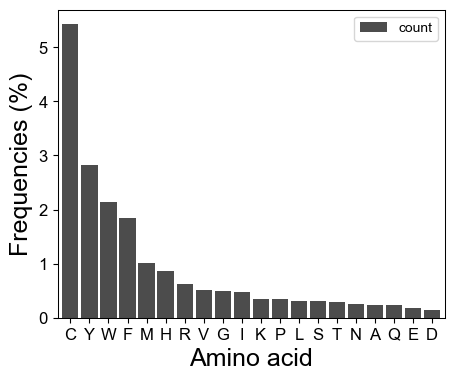

In [16]:
fig,ax = plt.subplots(figsize=[5,4])
cross_linked_frequencies_results.plot.bar(rot=0,width=0.85,color='k',alpha=0.7,ax=ax)
ax.set_xlabel("Amino acid")
ax.set_ylabel("Frequencies (%)")
fig.savefig(f"{out_dir}/Cross_linking_frequencies_amino_acids_barplot.pdf",dpi=400)

### Now for the chemical properties:

In [17]:
cross_linked_features_frequencies = defaultdict(float)
for feat in cross_linked_features:
    cross_linked_counts = cross_linked_features[feat]
    total_counts = all_amino_acid_features[feat]
    cross_linked_features_frequencies[feat] = cross_linked_counts/total_counts

In [18]:
cross_linked_feats_frequencies_results = pd.DataFrame.from_dict(cross_linked_features_frequencies,orient='index',columns=['count'])
cross_linked_feats_frequencies_results = cross_linked_feats_frequencies_results.apply(lambda x: x*100)
cross_linked_feats_frequencies_results.sort_values(by='count',ascending=False,inplace=True)
#save copy as text file
cross_linked_feats_frequencies_results.to_csv(f"{out_dir}/Cross-linking_features_frequencies.txt",sep="\t")
#save copy in database
#dataframeToSQLite_append_only_new(cross_linked_feats_frequencies_results,'Cross_linking_features_frequencies',database_name)

In [19]:
fig,ax = plt.subplots(figsize=[5,4])
cross_linked_feats_frequencies_results.plot.bar(rot=0,width=0.85,color='k',alpha=0.7,ax=ax)
ax.set_xlabel("Amino acid")
ax.set_ylabel("Frequency (%)")
fig.savefig(f"{out_dir}/Cross_linking_frequencies_features_barplot.pdf",dpi=400)

### Join plots:

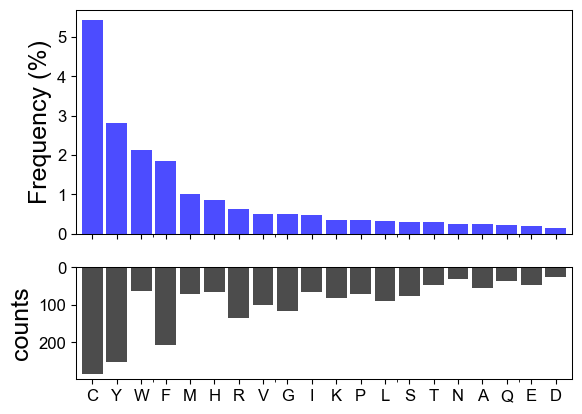

In [20]:
df_aminoacids = pd.merge(amino_acids_count_results,cross_linked_frequencies_results, left_index=True, right_index=True)
df_aminoacids.columns = ['counts','freq']
df_aminoacids = df_aminoacids.sort_values(by='freq',ascending=False)

fig = plt.figure()
# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
# the first subplot
ax0 = plt.subplot(gs[0])
p0 = df_aminoacids.freq.plot.bar(rot=0,width=0.85,color='b',alpha=0.7,ax=ax0)
ax0.set_ylabel("Frequency (%)")
# the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
p1 = df_aminoacids.counts.plot.bar(rot=0,width=0.85,color='k',alpha=0.7,ax=ax1)
plt.setp(ax0.get_xticklabels(), visible=False)
ax1.set_ylabel("counts")
ax1.invert_yaxis()
# remove last tick label for the second subplot
#yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
#plt.subplots_adjust(hspace=.0)
fig.savefig(f"{out_dir}/Cross_linking_amino_acids_counts_and_frequency_joined_barplot.pdf",dpi=400)

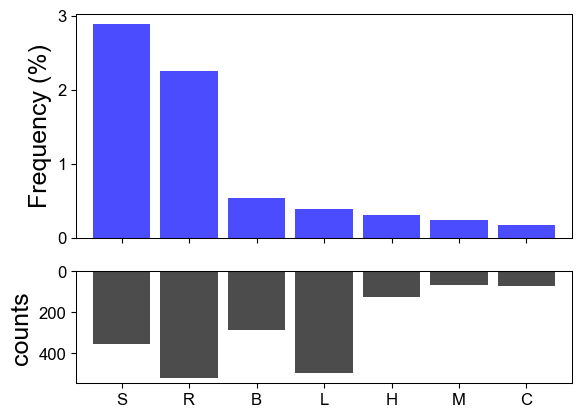

In [21]:
df_features = pd.merge(cross_linked_features_results,cross_linked_feats_frequencies_results, left_index=True, right_index=True)
df_features.columns = ['counts','freq']
df_features = df_features.sort_values(by='freq',ascending=False)

fig = plt.figure()
# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
# the first subplot
ax0 = plt.subplot(gs[0])
p0 = df_features.freq.plot.bar(rot=0,width=0.85,color='b',alpha=0.7,ax=ax0)
ax0.set_ylabel("Frequency (%)")
# the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
p1 = df_features.counts.plot.bar(rot=0,width=0.85,color='k',alpha=0.7,ax=ax1)
plt.setp(ax0.get_xticklabels(), visible=False)
ax1.set_ylabel("counts")
ax1.invert_yaxis()
# remove last tick label for the second subplot
#yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
#plt.subplots_adjust(hspace=.0)
fig.savefig(f"{out_dir}/Cross_linking_features_counts_and_frequency_joined_barplot.pdf",dpi=400)

### Done